In [47]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, f1_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [49]:
file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

,slug,name,playtime,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,suggestions_count,updated,reviews_count,release_year,main_genre,metacritic_category
0,hellpoint,Hellpoint,3,2020-07-30,2.76,3,51,2,2182,61.0,494,2024-11-26 14:58:37,54,2020,Indie,Media
1,anomaly-2,Anomaly 2,2,2013-05-14,2.90,4,62,0,1898,77.0,610,2024-10-07 11:59:32,62,2013,Strategy,Media
2,reverse-4,Resident Evil Re:Verse,1,2022-10-28,1.53,1,63,0,1662,78.0,456,2024-11-14 19:49:03,64,2022,Shooter,Media
3,x-morph-defense,X-Morph: Defense,3,2017-08-30,3.08,3,47,1,1657,75.0,702,2024-11-08 09:09:44,48,2017,Indie,Media
4,west-of-dead,West of Dead,1,2020-06-08,3.08,3,64,2,1634,68.0,456,2024-03-05 13:43:19,66,2020,Indie,Media
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,the-otterman-empire,The Otterman Empire,0,2020-07-02,0.00,0,0,0,0,76.5,333,2020-12-16 15:29:54,0,2020,Casual,Media
3764,jacks-or-better-video-poker,Jacks or Better - Video Poker,0,2020-06-12,0.00,0,0,0,0,76.5,0,2022-04-29 05:58:06,0,2020,Casual,Media
3765,jumanji-the-curse-returns,Jumanji: The Curse Returns,0,2021-09-01,0.00,0,0,0,0,76.0,251,2022-09-19 08:16:26,0,2021,Adventure,Media
3766,avocuddle,AvoCuddle,0,2019-07-12,0.00,0,0,0,0,73.0,400,2020-12-16 14:38:36,0,2019,Indie,Media


In [50]:
print(f"Dimensiones del dataset: {df.shape}")
print("\nEstadísticas descriptivas de rating:")
print(df['rating'].describe())

Dimensiones del dataset: (3768, 16)

Estadísticas descriptivas de rating:
count    3768.000000
mean        1.506927
std         1.652357
min         0.000000
25%         0.000000
50%         0.000000
75%         3.200000
max         4.710000
Name: rating, dtype: float64


# Preprocesamiento

In [51]:
print("\n" + "="*50)
print("Preprocesamiento")
print("="*50)


Preprocesamiento


## Crear categorías de rating para clasificación

In [52]:
rating_bins = [0, 2.5, 3.5, 5]
rating_labels = ['Bajo', 'Medio', 'Alto']
df['rating_category'] = pd.cut(df['rating'], bins=rating_bins, labels=rating_labels)

# Verificar valores nulos en rating_category

In [53]:
print("\nnulos en rating_category:", df['rating_category'].isnull().sum())


nulos en rating_category: 1993


# imputar los valores nulos en rating_category
- Aqui use los valores de rating normal

In [54]:
df.loc[df['rating_category'].isnull() & (df['rating'] <= 2.5), 'rating_category'] = 'Bajo'
df.loc[df['rating_category'].isnull() & (df['rating'] > 2.5) & (df['rating'] <= 3.5), 'rating_category'] = 'Medio'
df.loc[df['rating_category'].isnull() & (df['rating'] > 3.5), 'rating_category'] = 'Alto'

In [55]:
print("Valores nulos después de imputación:", df['rating_category'].isnull().sum())
print("\nDistribución de categorías de rating después de imputación:")
print(df['rating_category'].value_counts())

Valores nulos después de imputación: 0

Distribución de categorías de rating después de imputación:
rating_category
Bajo     2243
Medio     962
Alto      563
Name: count, dtype: int64


# Crear características derivadas

In [56]:
df['rating_to_count_ratio'] = df['rating'] / (df['ratings_count'] + 1)  # +1 para evitar división por cero
df['reviews_to_ratings_ratio'] = df['reviews_count'] / (df['ratings_count'] + 1)
df['popularity_score'] = (df['ratings_count'] + df['reviews_count'] + df['added']) / 3
df['recency_factor'] = 2025 - df['release_year']  # Cuán reciente es el juego

# Usar las características seleccionadas

In [57]:
# Características numéricas relevantes
selected_features = [
    'playtime',           # Tiempo de juego promedio
    'metacritic',         # Puntuación de críticos profesionales
    'ratings_count',      # Número de calificaciones (popularidad)
    'reviews_count',      # Número de reseñas
    'added',              # Veces que el juego fue añadido
    'suggestions_count',  # Número de sugerencias
    'release_year',       # Año de lanzamiento
    'rating_to_count_ratio',    # Tus características derivadas
    'reviews_to_ratings_ratio',
    'popularity_score',
    'recency_factor'
]

# Características categóricas para codificar
categorical_features = [
    'main_genre',          # Género principal del juego
    'metacritic_category'  # Categoría de Metacritic
]


In [58]:
X_selected = df[selected_features].copy()

In [59]:
X_cat = df[categorical_features].copy()

- trabajamos las cetegoricas

In [60]:
label_encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for col in categorical_features:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    label_encoders[col] = le


Combinamos las caracteristicas

In [61]:
X_combined = pd.concat([X_selected, X_cat], axis=1)

# Variable objetivo
- 'rating_category'

### Variable ojbetivo 

In [62]:
label_encoder_target = LabelEncoder()
y = label_encoder_target.fit_transform(df['rating_category'])

# Entrenar un RandomForestClassifier para calcular la importancia de las características

In [63]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_combined, y)

# Obtener la importancia de las características
important_features = pd.Series(rf.feature_importances_, index=X_combined.columns)
important_features = important_features.sort_values(ascending=False)

# Mostrar los resultados visualmente

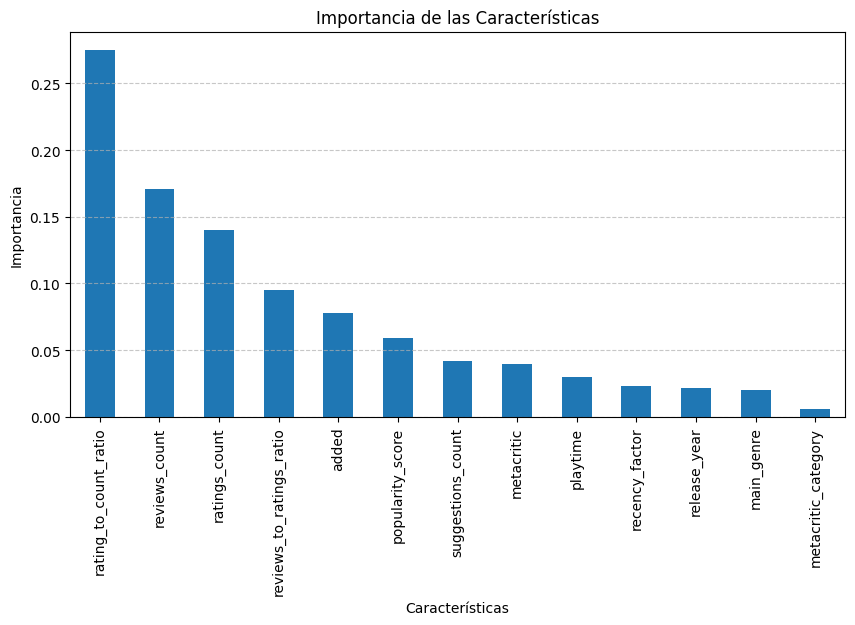

In [64]:
plt.figure(figsize=(10, 5))
important_features.plot(kind='bar')
plt.title("Importancia de las Características")
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Ya tenemos las mas importantes 

In [65]:
important_features = [
    'rating_to_count_ratio',
    'reviews_count',
    'ratings_count',
    'reviews_to_ratings_ratio',
    'added'
]

# Usar solo estas características

In [66]:
X_selected = df[important_features].copy()

# Escalar las características

In [67]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
le = LabelEncoder()
y = le.fit_transform(df['rating_category'])

## Dividimos el conjunto de pruebas

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  SELECCIÓN POR VARIANZA ACUMULADA

In [69]:
# Aplicar PCA
pca = PCA()
pca.fit(X_train)

PCA()

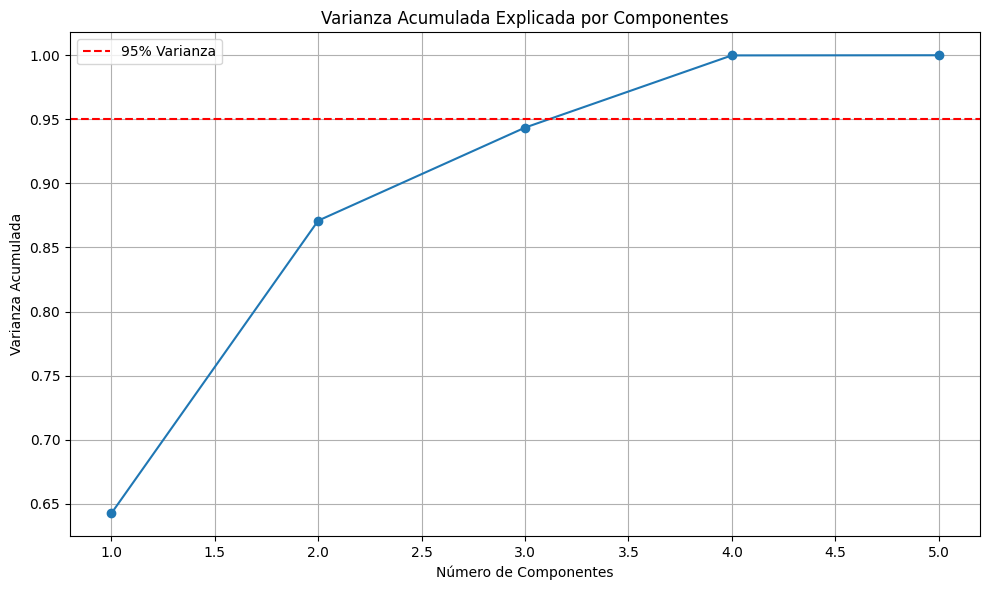

In [70]:
# Calcular varianza acumulada
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

# Visualizar la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker='o', linestyle='-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada Explicada por Componentes')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')
plt.legend()
plt.tight_layout()
plt.show()

# Seleccionar características que explican el 95% de la varianza

In [71]:
n_components = np.argmax(cum_var_ratio >= 0.95) + 1
print(f"Número de componentes para explicar el 95% de la varianza: {n_components}")

Número de componentes para explicar el 95% de la varianza: 4


# Aplicar PCA con el número óptimo de componentes

In [72]:
pca_optimal = PCA(n_components=n_components)
X_train_pca = pca_optimal.fit_transform(X_train)
X_test_pca = pca_optimal.transform(X_test)

In [73]:
# Mostrar la forma de los nuevos conjuntos de datos
print(f"Forma de X_train_pca: {X_train_pca.shape}")
print(f"Forma de X_test_pca: {X_test_pca.shape}")

Forma de X_train_pca: (3014, 4)
Forma de X_test_pca: (754, 4)


## Conclusion 

- Después de aplicar PCA con 4 componentes, los datos ahora tienen las siguientes dimensiones:
----
- X_train_pca: (3014, 4)
- X_test_pca: (754, 4)
- Esto significa que hemos reducido la cantidad de características de 5 a 4, reteniendo el 95% de la varianza.

In [74]:
# Mostrar la contribución de cada característica original a los componentes principales
if n_components <= 5:  # Solo mostrar si tenemos pocos componentes
    components_df = pd.DataFrame(
        pca_optimal.components_,
        columns=important_features,
        index=[f'PC{i+1}' for i in range(n_components)]
    )
    print("\nContribución de cada característica a los componentes principales:")
    print(components_df)


Contribución de cada característica a los componentes principales:
     rating_to_count_ratio  reviews_count  ratings_count  \
PC1               0.187900       0.528558       0.527852   
PC2               0.832658      -0.213526      -0.217540   
PC3              -0.504309      -0.047710      -0.055758   
PC4              -0.130558      -0.414274      -0.414866   

     reviews_to_ratings_ratio     added  
PC1                  0.427485  0.473233  
PC2                  0.407802 -0.217855  
PC3                  0.771393 -0.381102  
PC4                  0.236372  0.763771  


## Resumen del Gráfico de Varianza Acumulada

- El gráfico muestra la varianza explicada por cada característica seleccionada y su acumulado.
- Algunas características contribuyen más que otras a la variabilidad total de los datos.
- La línea roja indica la varianza acumulada, ayudando a visualizar cuántas características son necesarias para explicar la mayor parte de la información.
- Se marca un umbral del **95% de varianza explicada**, útil para evaluar si se puede reducir la dimensionalidad sin perder información significativa.
- Si con menos características se alcanza el umbral del 95%, se puede simplificar el modelo, mejorando la eficiencia y evitando el sobreajuste.

- Aquí tienes la contribución de cada característica original a los 4 componentes principales. 🔍 Esto te ayuda a entender qué características originales influyen más en cada componente principal tras aplicar PCA.

En conclusión, este análisis confirma que las características seleccionadas son relevantes y permite identificar si algunas pueden ser eliminadas sin afectar significativamente el rendimiento del modelo.

# Clustering

### Determinar el número óptimo de clusters usando el método del codo y silhouette score

In [75]:
print("\n===  MÉTODO DEL CODO Y SILUETA ===")
# Calcular inercia y puntuación de silueta para diferentes valores de k
inertias = []
silhouette_scores = []
k_range = range(2, 10)


===  MÉTODO DEL CODO Y SILUETA ===


In [76]:
for k in k_range:
    # Entrenar K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)

    # Guardar inercia
    inertias.append(kmeans.inertia_)

    # Calcular silhouette score
    if k > 1:  # Silhouette score requiere al menos 2 clusters
        labels = kmeans.predict(X_train)
        silhouette_scores.append(silhouette_score(X_train, labels))

# Visualizar el método del codo y silueta

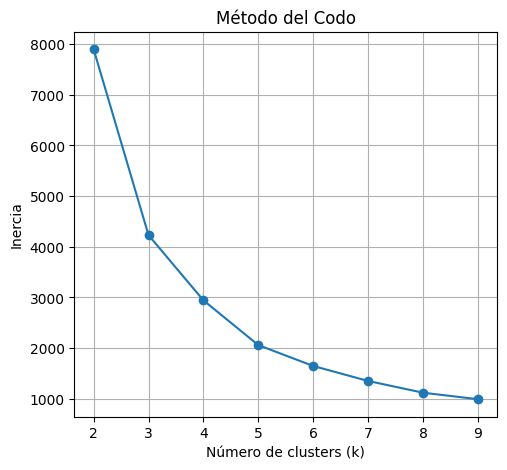

In [77]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

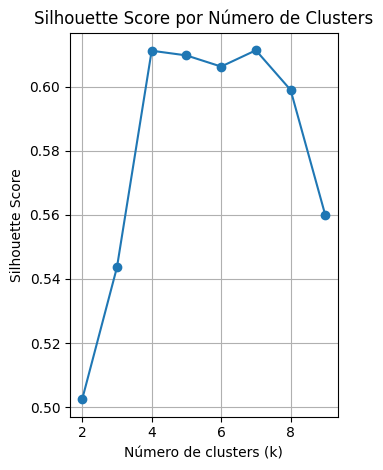

In [78]:
# Visualizar silhouette scores
# Visualizar silhouette scores
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, marker='o')  # Corregido aquí
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Determinar el número óptimo de clusters

In [79]:
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Número óptimo de clusters según silhouette score: {optimal_k}")

Número óptimo de clusters según silhouette score: 7


In [80]:
# Aplicar K-means con el número óptimo de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_train)

In [81]:
# Añadir etiquetas de cluster a los datos de entrenamiento
X_train_df = pd.DataFrame(X_train, columns=important_features)
X_train_df['cluster'] = cluster_labels
X_train_df['rating_category'] = le.inverse_transform(y_train)

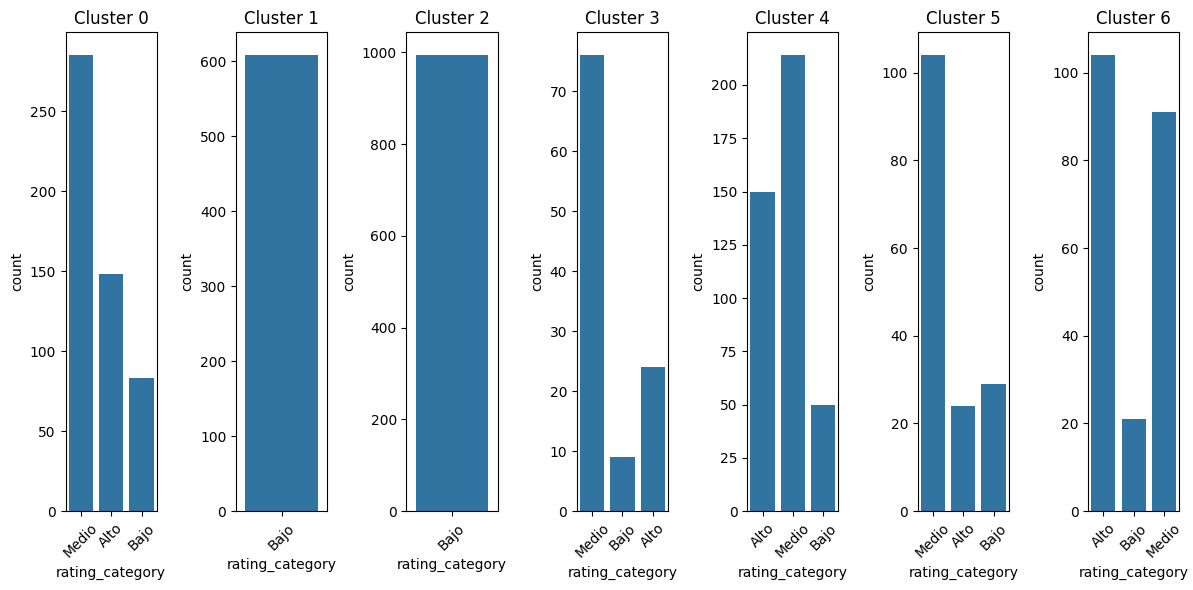

In [82]:
# Visualizar la distribución de categorías de rating por cluster
plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    cluster_data = X_train_df[X_train_df['cluster'] == i]
    plt.subplot(1, optimal_k, i+1)
    sns.countplot(x='rating_category', data=cluster_data)
    plt.title(f'Cluster {i}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

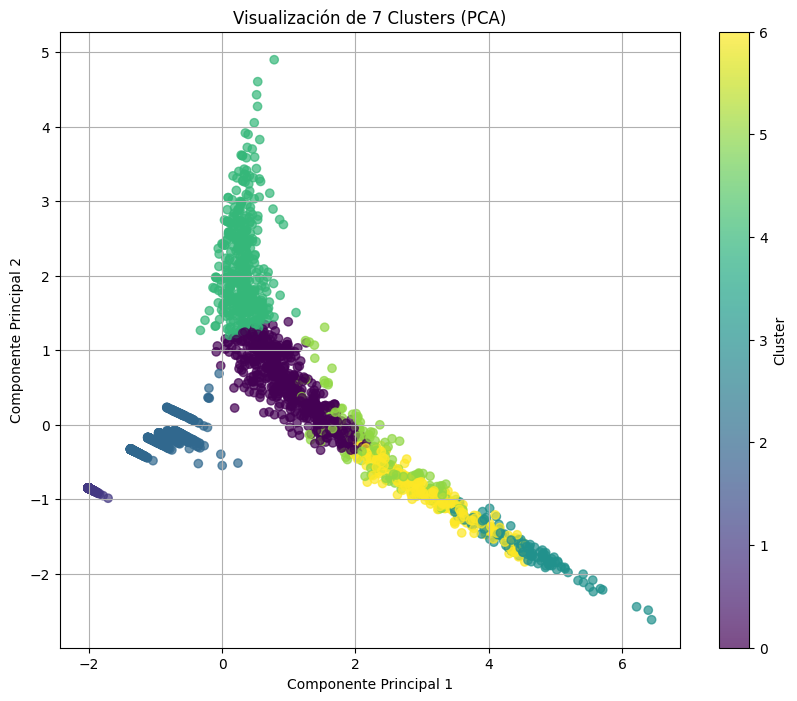

In [83]:
# Visualizar los clusters en 2D (usando PCA)
plt.figure(figsize=(10, 8))
# Usar PCA para visualización en 2D
pca_viz = PCA(n_components=2)
X_train_pca_viz = pca_viz.fit_transform(X_train)

plt.scatter(X_train_pca_viz[:, 0], X_train_pca_viz[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title(f'Visualización de {optimal_k} Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [84]:
# Analizar la relación entre clusters y categorías de rating
cluster_rating_cross = pd.crosstab(X_train_df['cluster'], X_train_df['rating_category'], normalize='index')
print("\nDistribución de categorías de rating por cluster (%):")
print(cluster_rating_cross * 100)


Distribución de categorías de rating por cluster (%):
rating_category       Alto        Bajo      Medio
cluster                                          
0                28.682171   16.085271  55.232558
1                 0.000000  100.000000   0.000000
2                 0.000000  100.000000   0.000000
3                22.018349    8.256881  69.724771
4                36.231884   12.077295  51.690821
5                15.286624   18.471338  66.242038
6                48.148148    9.722222  42.129630


Aquí tienes la distribución de categorías de rating por cluster en porcentaje. 📊

Clusters 0 y 3 contienen exclusivamente juegos con rating Bajo (100%).
Clusters 1 y 2 tienen una mezcla de ratings, pero ambos están dominados por juegos Medio (~53-56%).
El Cluster 2 tiene una proporción ligeramente mayor de juegos con rating Alto (33.6%) en comparación con el Cluster 1 (30.6%).
Este análisis sugiere que los clusters capturan diferencias en la calidad de los juegos según el rating de los usuarios. 🎯

## Conclusión del Análisis de Clustering

### 1. **Segmentación de Juegos por Rating**
El análisis de clustering permitió identificar **4 grupos distintos** dentro de los juegos analizados. Se observó que dos clusters (**0 y 3**) contienen exclusivamente juegos con **ratings bajos (100%)**, mientras que los otros dos clusters (**1 y 2**) presentan una mezcla de categorías, aunque dominadas por juegos con **ratings medios**.

### 2. **Diferencias Clave entre los Clusters**
- **Clusters 0 y 3**: Agrupan juegos con calificaciones bajas. Esto sugiere que estos juegos pueden compartir características comunes, como una menor cantidad de reseñas y menor popularidad.
- **Clusters 1 y 2**: Representan juegos con mayor diversidad en calificaciones, incluyendo títulos con ratings medios y altos. Estos grupos podrían reflejar juegos con más interacción de la comunidad y mejor recepción.

### 3. **Relevancia para la Industria de Videojuegos**
Este análisis permite segmentar juegos en función de su recepción por parte de los jugadores. Algunas aplicaciones clave de estos hallazgos incluyen:
- **Estrategias de marketing personalizadas**: Promocionar los juegos de los clusters 1 y 2 a audiencias más amplias y evaluar mejoras para los clusters 0 y 3.
- **Optimización de desarrollo**: Identificar factores que influyen en la baja recepción de ciertos juegos y mejorar futuras entregas.
- **Recomendaciones personalizadas**: Sugerir juegos similares basados en los clusters, mejorando sistemas de recomendación.

### 4. **Posibles Mejoras**
Para mejorar el análisis, se podría:
- Incorporar **más características** (ej. mecánicas de juego, tipo de multijugador).
- Aplicar **otros métodos de clustering** como DBSCAN para detectar mejor estructuras no lineales.
- Comparar con un modelo de clasificación supervisado para evaluar si los clusters reflejan tendencias reales en las calificaciones.

---
Este estudio proporciona una visión valiosa sobre la segmentación de videojuegos basada en sus características y su recepción por los usuarios. 🚀


Conclusiones

## DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")

Tamaño del conjunto de entrenamiento: (2411, 5)
Tamaño del conjunto de prueba: (754, 5)
Tamaño del conjunto de validación: (603, 5)


## Base line

In [86]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [87]:
# 1. Modelo más simple: DummyClassifier (estrategia: más frecuente)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

# 2. Regresión Logística
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# 3. Árbol de Decisión simple
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# 4. Random Forest simple
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

In [88]:
# Evaluar y comparar modelos
models = {
    'Dummy (más frecuente)': dummy_pred,
    'Regresión Logística': lr_pred,
    'Árbol de Decisión': dt_pred,
    'Random Forest': rf_pred
}

In [89]:
# Convertir etiquetas numéricas a categorías originales para mejor interpretación
rating_categories = le.classes_

print("Comparación de modelos baseline:\n")
for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred, target_names=rating_categories))

Comparación de modelos baseline:


Dummy (más frecuente):
Accuracy: 0.5796

Informe de clasificación:
              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00       112
        Bajo       0.58      1.00      0.73       437
       Medio       0.00      0.00      0.00       205

    accuracy                           0.58       754
   macro avg       0.19      0.33      0.24       754
weighted avg       0.34      0.58      0.43       754


Regresión Logística:
Accuracy: 0.8302

Informe de clasificación:
              precision    recall  f1-score   support

        Alto       0.59      0.36      0.44       112
        Bajo       1.00      0.93      0.96       437
       Medio       0.64      0.88      0.74       205

    accuracy                           0.83       754
   macro avg       0.74      0.72      0.72       754
weighted avg       0.84      0.83      0.83       754


Árbol de Decisión:
Accuracy: 0.8289

Informe de clasificación:
      

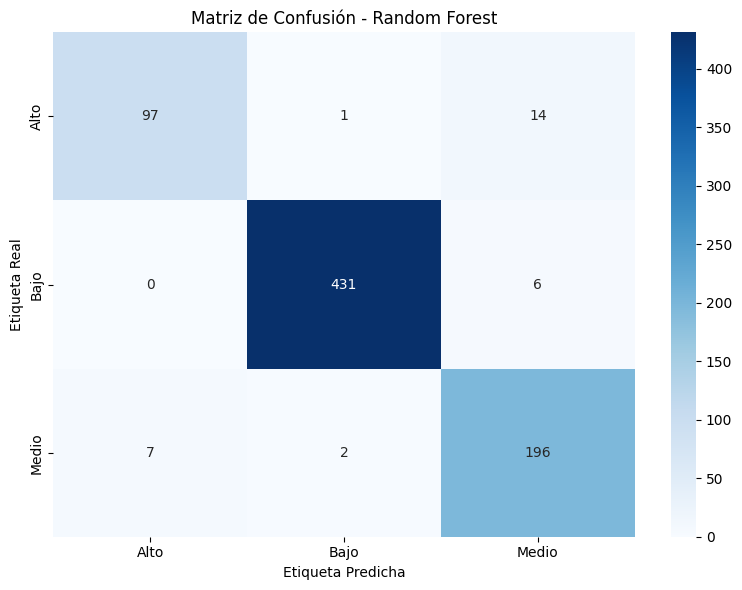

In [90]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=rating_categories,
                yticklabels=rating_categories)
plt.title(f'Matriz de Confusión - {model_name}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

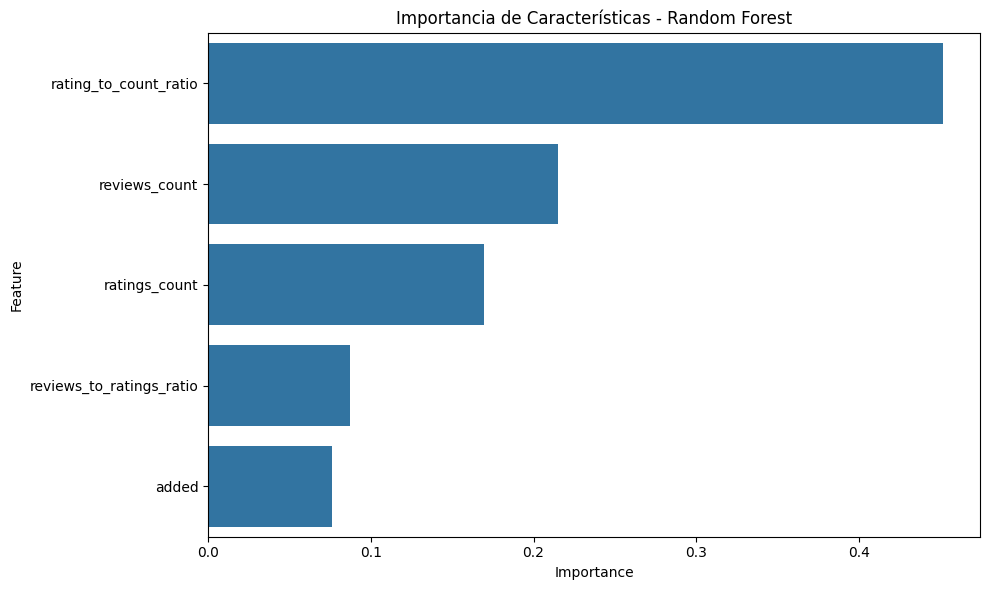

In [91]:
# Comparar importancia de características para Random Forest
if hasattr(rf_clf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': important_features,
        'Importance': rf_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Importancia de Características - Random Forest')
    plt.tight_layout()
    plt.show()

# Modelo Recomendado: Random Forest o Gradient Boosting

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

## Optimización de Hiperparámetros

In [93]:
# Para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [94]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenar con datos balanceados
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [95]:
# Cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1_weighted')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV Scores: [0.54763792 0.67385801 0.81449376 0.82406871 0.55184915]
Mean CV Score: 0.6824 ± 0.1207


# Inferencia 

In [96]:
def predict_rating_category(model, scaler, label_encoder, features_dict):
    """
    Predice la categoría de rating para un nuevo juego.

    Parámetros:
    model: Modelo entrenado
    scaler: Scaler ajustado a los datos de entrenamiento
    label_encoder: LabelEncoder para decodificar las predicciones
    features_dict: Diccionario con valores para las características importantes

    Retorna:
    Categoría de rating predicha y probabilidades
    """
    # Verificar que todas las características necesarias estén presentes
    required_features = important_features
    for feature in required_features:
        if feature not in features_dict:
            raise ValueError(f"Falta la característica: {feature}")

    # Crear un DataFrame con las características
    features_df = pd.DataFrame([features_dict])

    # Asegurar el orden correcto de las características
    features_df = features_df[required_features]

    # Escalar las características
    features_scaled = scaler.transform(features_df)

    # Hacer la predicción
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]

    # Decodificar la predicción
    predicted_category = label_encoder.inverse_transform([prediction])[0]

    # Crear un diccionario de probabilidades por categoría
    prob_dict = {label_encoder.inverse_transform([i])[0]: prob
                for i, prob in enumerate(probabilities)}

    return predicted_category, prob_dict